In [ ]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '25'
os.environ['MKL_NUM_THREADS'] = '25'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
import copy
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import xarray as xr
import pickle
import random
import time
import signal
import multiprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import lightgbm as lgb
import itertools

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
import postprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from gbdtmo import GBDTMulti, load_lib


# 1. Read Data

In [2]:
### PM2.5


data_pm25 = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/PM25/FullPM2.5.csv',index_col=0,parse_dates=True)
short_stations = ['SAB-JOFE','MED-UNNV','GIR-TEMP','GIR-SOSN','GIR-EPM','MED-FISC']
# data_pm25.index = data_pm25.index-dt.timedelta(hours = 1) 
data_pm25 = data_pm25.drop(short_stations,axis = 1)
stations = np.sort(data_pm25.keys())

data_pm25_orig = data_pm25
data_pm25 = data_pm25['2017-10-01':'2020-04-01']

anomalous_stations = ['CEN-TRAF','SUR-TRAF']
df_temp = data_pm25.drop(anomalous_stations,axis = 1)
data_pm25_copy = copy.deepcopy(data_pm25) ## Copy if I have to come back

def clean_abrupt_gradient(anoms):
    diff = abs(np.diff(anoms))
    anoms[np.hstack([diff>=1.5,np.array([False])])] = np.nan
    anoms[np.hstack([np.array([False]),diff>=1.5])] = np.nan
    return pd.Series(anoms,index = anoms.index)
df_mean = pd.DataFrame(data_pm25.drop(anomalous_stations,axis = 1).mean(axis = 1))
data_temp = copy.deepcopy(df_mean)
df_mean = data_temp
df_mean.columns = ['PM25_stations']


### CAMS

data_CAMS = postprocessing.call_files('CAMS')
data_CAMS = postprocessing.recorte_espacial(data_CAMS)

dataset_full = data_CAMS

lat_cams = dataset_full.latitude.values
lon_cams = dataset_full.longitude.values

aod = np.nanmean(dataset_full.aod550.values,axis = (1,2))#[:].data
bcaod = np.nanmean(dataset_full.bcaod550.values,axis = (1,2))#[:].data
pm2p5_cams = np.nanmean(dataset_full.pm2p5.values,axis = (1,2)) #* 1000_000_000

df_cams = pd.DataFrame(np.array([aod,bcaod,pm2p5_cams]).T,index= dataset_full.time.values,
    columns = ['aod','bcaod','pm2p5_cams'])
# df_cams = pd.DataFrame(np.array([aod,pm2p5_cams]).T,index= dataset_full.time.values,
#     columns = ['aod','pm2p5_cams'])
# df_cams = (df_cams.rolling(3,center=True).mean())
df_cams.index = df_cams.index - dt.timedelta(hours = 5)



df_CAMS_hourly = df_cams.resample('H').mean().interpolate(method = 'linear',order = 3)
df_CAMS_hourly.index = df_CAMS_hourly.index

df_hourly_chem = pd.concat([df_mean,df_CAMS_hourly],axis=1).dropna()

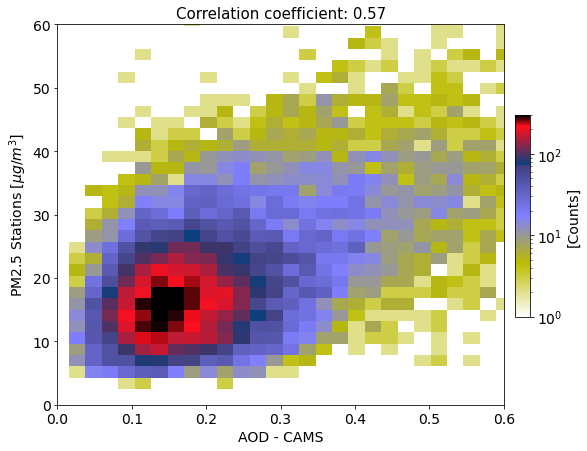

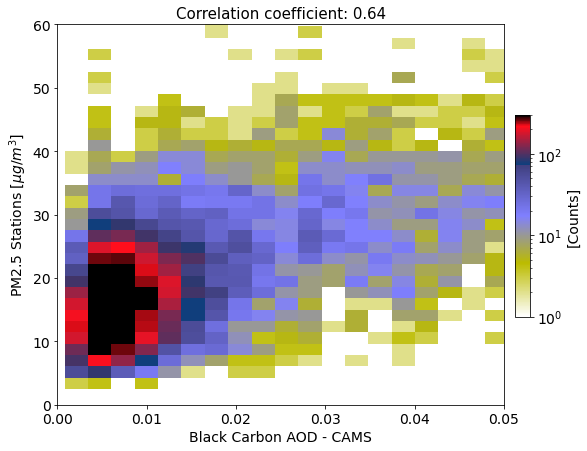

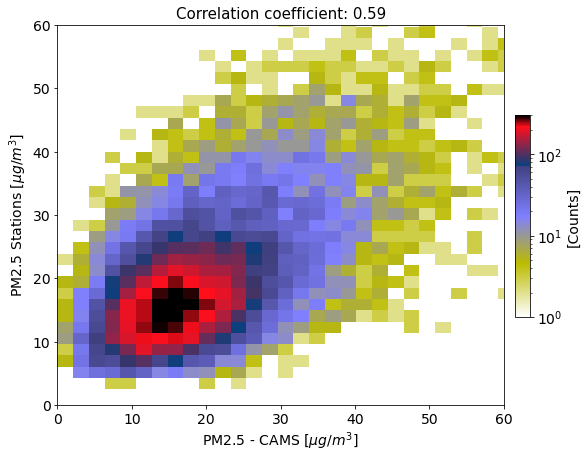

In [3]:
names_cams = ['AOD - CAMS','Black Carbon AOD - CAMS','PM2.5 - CAMS [$\mu g / m^3$]']

for i,var_cams in enumerate(df_hourly_chem.keys()[1:]):
    corr = np.corrcoef(df_hourly_chem[var_cams],df_hourly_chem.PM25_stations)[0][1]
    plt.figure(figsize=(8,7))
    CS = plt.hist2d(df_hourly_chem[var_cams],df_hourly_chem.PM25_stations,bins = [50,50],
                    cmap='gist_stern_r',vmax = 300,norm=LogNorm()
                   )
    plt.xlim(0,[0.6,0.05,60,60][i])
    plt.ylim(0,60)
    plt.title('Correlation coefficient: '+str(np.round(corr,2)),fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel(names_cams[i],fontsize=14)
    plt.ylabel('PM2.5 Stations [$\mu g / m^3$]',fontsize=14)
    # plt.legend(fontsize=16)

    cax = plt.axes([0.92, 0.3, 0.025, 0.4])
    cbar = plt.colorbar(CS[3], cax=cax)
    cbar.set_label(u'[Counts]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()

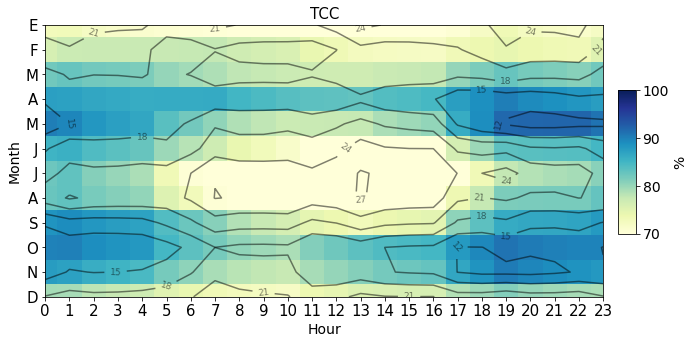

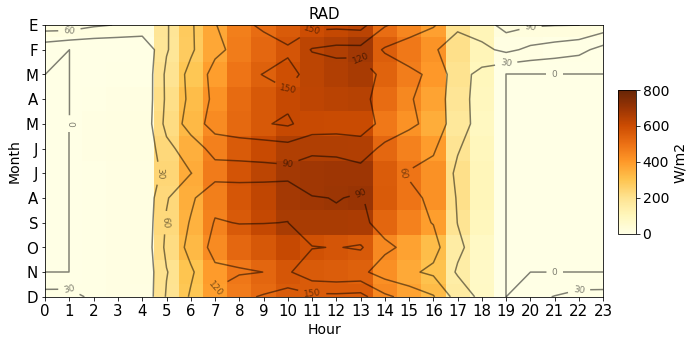

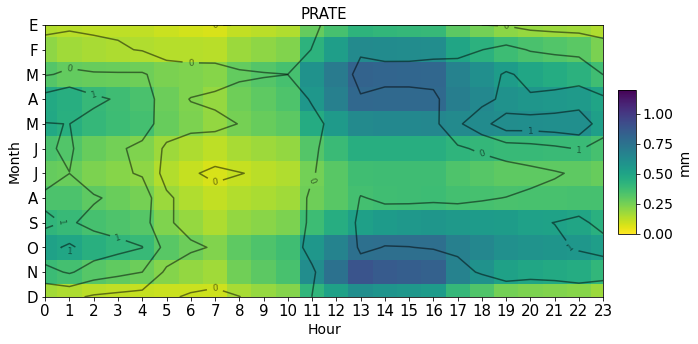

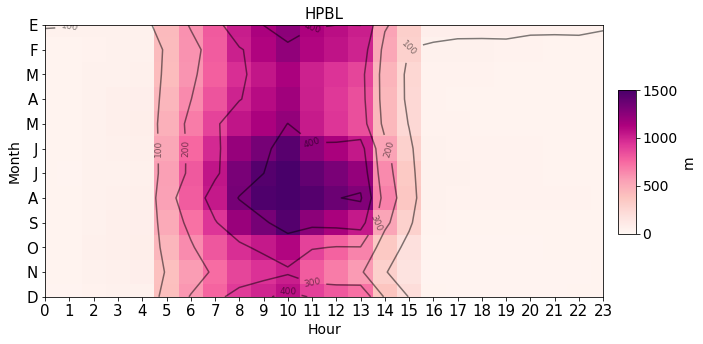

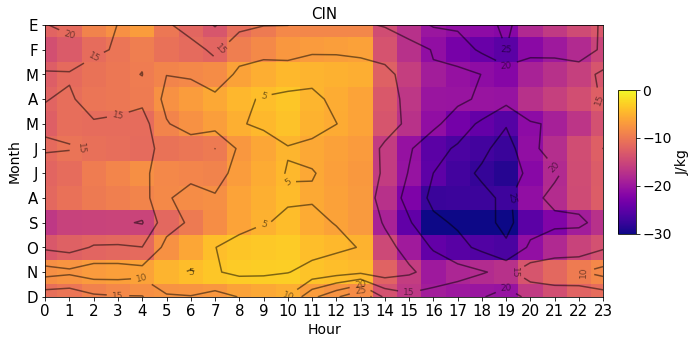

In [4]:
df_GFS_hourly = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/GFS/GFS_Mean_Hourly_v2.csv',\
                            index_col = 0, parse_dates=True)
limits = [(70,100),(0,800),(0,1.2),(0,1500),(-30,0)]
colormaps_meteo = ['YlGnBu','YlOrBr','viridis_r','RdPu','plasma']
# keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)
keys_gfs = ['tcc','rad','prate','hpbl','cin']
months_of_year_str = ['E','F','M','A','M','J','J','A','S','O','N','D']
units = ['%', 'W/m2', 'mm', 'm', 'J/kg']

for ivariable in range(len(keys_gfs)):
    df_temp = df_GFS_hourly[keys_gfs[ivariable]]
    mean_temp = np.zeros([12,24])
    std_temp = np.zeros([12,24])
    for monthi in range(1,13):
        for houri in range(0,24):
            mean_temp[monthi-1,houri] = np.nanmean(df_temp[(df_temp.index.month == monthi)&\
                                                           (df_temp.index.hour == houri)])
            std_temp[monthi-1,houri] = np.nanstd(df_temp[(df_temp.index.month == monthi)&\
                                                           (df_temp.index.hour == houri)])

    months_of_year = np.arange(1,13)
    hours_of_day = np.arange(0,24)

    months_of_year_plot = np.arange(0.5,13.5,1)
    hours_of_day_plot = np.arange(-0.5,24,1)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    mini=limits[ivariable][0]
    maxi=limits[ivariable][1]
    intervals = 21
    bounds=np.linspace(mini,maxi,intervals)

    CS = plt.pcolormesh(hours_of_day_plot,months_of_year_plot,mean_temp,vmin=mini,vmax=maxi,\
                        cmap = colormaps_meteo[ivariable])
    CT = plt.contour(hours_of_day,months_of_year,std_temp,5,colors='k',alpha = 0.5)
    ax.clabel(CT, fontsize=9, inline=1,fmt = '%1.0f')
    plt.yticks(months_of_year,months_of_year_str,fontsize=15)
    plt.xticks(hours_of_day,hours_of_day,fontsize=15)
    plt.ylim(12,1)
    plt.xlim(0,23)

    plt.xlabel('Hour',fontsize=14)
    plt.ylabel('Month',fontsize=14)

    plt.title(keys_gfs[ivariable].upper(),fontsize=15)

    cax = plt.axes([0.92, 0.3, 0.025, 0.4])
    cbar = plt.colorbar(CS, cax=cax)
    cbar.set_label(units[ivariable],fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()
#     plt.savefig('Figures/Characterization/Meteo/CACD_'+keys_gfs[ivariable]+'.png',bbox_inches='tight')

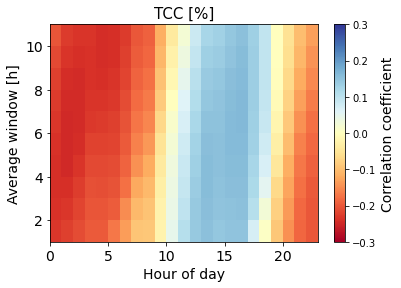

/home/jsperezc/py_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jsperezc/py_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


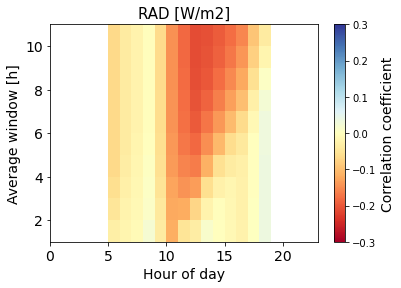

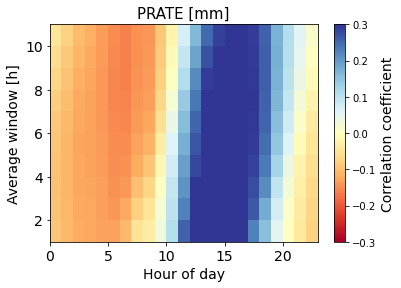

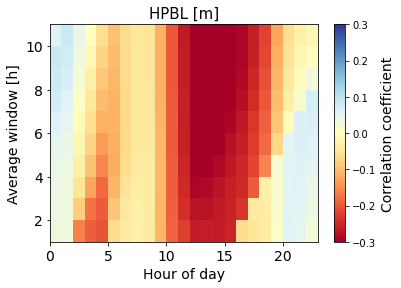

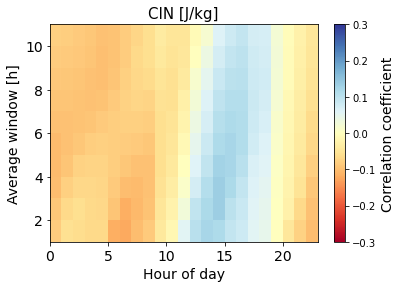

In [5]:
windows = np.arange(1,12)
hours = np.arange(0,24)

for variable_i,variable in enumerate(keys_gfs):
    matriz_corrs = np.zeros([len(windows),len(hours)])

    for window in windows:
        for hour_temp in hours:
            df_rolling = df_GFS_hourly.rolling(str(window)+'H',center=False, min_periods = window).mean()[variable]
            df_temp = pd.concat([df_rolling[df_rolling.index.hour==hour_temp],
                    df_hourly_chem[df_hourly_chem.index.hour==hour_temp].PM25_stations],axis = 1)
            df_temp = df_temp.dropna()
            corr = np.corrcoef(df_temp.iloc[:,0].values,df_temp.iloc[:,1].values)[0][1]
            matriz_corrs[window-1,hour_temp] = corr
    if variable == 'rad':
        matriz_corrs[:,:5] = np.nan
        matriz_corrs[:,19:] = np.nan
    plt.close('all')
    plt.title(variable.upper() +' ['+ units[variable_i]+']',fontsize=15)
    plt.pcolormesh(hours,windows,matriz_corrs,vmin = -0.3,vmax=0.3,cmap = 'RdYlBu')
    np.save('/var/data1/AQ_Forecast_DATA/historic/GFS/correlations/CorrsAnomsGFS_'+variable+'_v3.npy', matriz_corrs)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Hour of day',fontsize=14)
    plt.ylabel('Average window [h]', fontsize=14)
    cbar = plt.colorbar()
    cbar.set_label('Correlation coefficient',fontsize=14)
#     plt.savefig('Figures/Characterization/Meteo/Corrs_'+keys_gfs[variable_i]+'.png',bbox_inches='tight')
    plt.show()

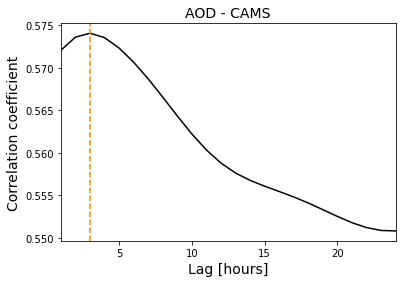

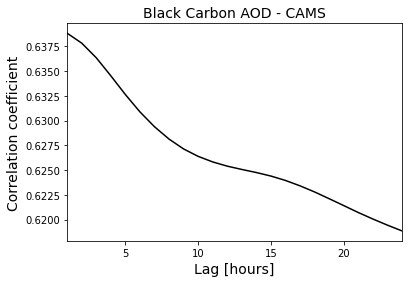

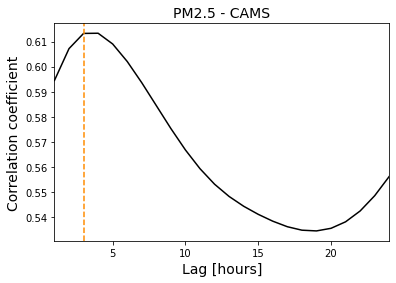

In [6]:
names_cams = ['AOD - CAMS','Black Carbon AOD - CAMS','PM2.5 - CAMS']

for i,var_cams in enumerate(df_hourly_chem.keys()[1:]):
    corrs_temp = []
    for lag in range(1,25):
        df_roll = df_hourly_chem[var_cams].rolling(lag).mean()
        conc = pd.concat([df_roll,df_hourly_chem.PM25_stations],axis=1).dropna()
        corrs_temp.append(np.corrcoef(conc.iloc[:,0],conc.iloc[:,1])[0,1])

    plt.plot(np.arange(1,25),corrs_temp,color='k')
    plt.axvline([3,0,3][i],color='darkorange',ls = '--',label = 'Max. Correlation')
    plt.title(names_cams[i],fontsize=14)
    plt.xlabel('Lag [hours]',fontsize=14)
    plt.ylabel('Correlation coefficient',fontsize=14)
    plt.xlim(1,24)
    plt.show()

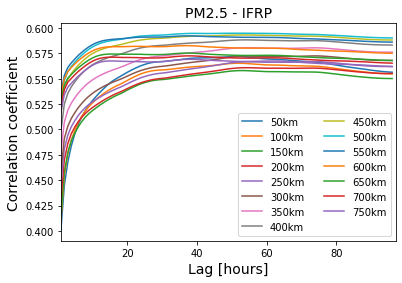

In [14]:
ifrp = pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/Fires/Processed/IFRP_Radios_800hpa_4dias.csv", 
                   usecols=[str(i) for i in np.arange(16)],index_col=0,parse_dates=True)
ifrp.index = ifrp.index-dt.timedelta(hours=5)
ifrp.columns = np.arange(50, 800, 50).astype(str)


for val in ifrp.columns:
    ifrp_temp = ifrp[[val]]

    corrs_temp = []
    for lag in range(1,97):
        df_roll = ifrp_temp[val].rolling(lag).mean()
        conc = pd.concat([df_roll,df_hourly_chem.PM25_stations],axis=1).dropna()
    #     corrs_temp.append(stats.spearmanr(conc.iloc[:,0],conc.iloc[:,1]).correlation)
        corrs_temp.append(np.corrcoef(conc.iloc[:,0],conc.iloc[:,1])[0,1])

    plt.plot(np.arange(1,97),corrs_temp,label=val+'km')
    plt.legend(ncol=2)
    plt.title('PM2.5 - IFRP',fontsize=14)
    plt.xlabel('Lag [hours]',fontsize=14)
    plt.ylabel('Correlation coefficient',fontsize=14)
    plt.xlim(1,97)
plt.show()

ifrp_optimal_50 = ifrp[['50']].rolling(24).mean()

In [15]:
### PREPARA DATOS DE ENTRADA

df_optimal_cams = pd.DataFrame(index = df_hourly_chem.index)
df_optimal_cams['aod'] = df_hourly_chem.aod.rolling(3).mean()
df_optimal_cams['bcaod'] = df_hourly_chem.bcaod.rolling(1).mean()
df_optimal_cams['pm2p5_cams'] = df_hourly_chem.pm2p5_cams.rolling(3).mean()

def get_optimal_window(variable,hour):
    return np.argmax(abs(np.load('/var/data1/AQ_Forecast_DATA/historic/GFS/correlations/CorrsAnomsGFS_'\
                                 +variable+'_v3.npy')[:,hour]))+1

df_optimal_gfs = pd.DataFrame(index = df_GFS_hourly.index)

for variable in keys_gfs:
    df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
    for hour in range(0,24):
        optimal_window = get_optimal_window(variable,hour)
        df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window).mean()\
            [df_optimal_temp.index.hour == hour]
    df_optimal_gfs[variable] = df_optimal_temp

In [16]:
df_hour = pd.DataFrame(df_hourly_chem.index.hour, index = df_hourly_chem.index)
df_hour1 = np.sin(2*np.pi*(df_hour/24))
df_hour2 = np.cos(2*np.pi*(df_hour/24))

df_dow = pd.DataFrame(df_hourly_chem.index.dayofweek, index = df_hourly_chem.index)
df_dow1 = np.sin(2*np.pi*(df_dow/7))
df_dow2 = np.cos(2*np.pi*(df_dow/7))

df_doy = pd.DataFrame(df_hourly_chem.index.dayofyear, index = df_hourly_chem.index)
df_doy1 = np.sin(2*np.pi*(df_doy/365))
df_doy2 = np.cos(2*np.pi*(df_doy/365))

# 2. Organize and Select Input Features

In [26]:
max_lag = 48
x_shifts = pd.concat([df_hourly_chem.PM25_stations.shift(i) for i in range(max_lag,0,-1)],axis = 1).dropna()
x_shifts.columns = np.array(['PM_'+str(i).zfill(2) for i in range(max_lag,0,-1)])

aod_future = pd.DataFrame(np.array([df_optimal_cams[['aod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['aod']].index,\
             columns = np.array(['AOD_'+str(i).zfill(2) for i in range(0,97,3)]))
bc_future = pd.DataFrame(np.array([df_optimal_cams[['bcaod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['bcaod']].index,\
             columns = np.array(['BCAOD_'+str(i).zfill(2) for i in range(0,97,3)]))
pm2p5_future = bc_future = pd.DataFrame(np.array([df_optimal_cams[['pm2p5_cams']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['pm2p5_cams']].index,\
             columns = np.array(['PMCAMS_'+str(i).zfill(2) for i in range(0,97,3)]))

tcc_future = pd.DataFrame(np.array([df_optimal_gfs[['tcc']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['tcc']].index,\
             columns = np.array(['tcc_'+str(i).zfill(2) for i in range(0,97,3)]))
rad_future = pd.DataFrame(np.array([df_optimal_gfs[['rad']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['rad']].index,\
             columns = np.array(['rad_'+str(i).zfill(2) for i in range(0,97,3)]))
prate_future = pd.DataFrame(np.array([df_optimal_gfs[['prate']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['prate']].index,\
             columns = np.array(['prate_'+str(i).zfill(2) for i in range(0,97,3)]))
hpbl_future = pd.DataFrame(np.array([df_optimal_gfs[['hpbl']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['hpbl']].index,\
             columns = np.array(['hpbl_'+str(i).zfill(2) for i in range(0,97,3)]))
cin_future = pd.DataFrame(np.array([df_optimal_gfs[['cin']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['cin']].index,\
             columns = np.array(['cin_'+str(i).zfill(2) for i in range(0,97,3)]))


ifrp50_future = pd.DataFrame(np.array([ifrp_optimal_50[['50']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = ifrp_optimal_50[['50']].index,\
             columns = np.array(['ifrp50_'+str(i).zfill(2) for i in range(0,97,3)]))

dow1_future = pd.DataFrame(np.array([df_dow1[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow1[[0]].index,\
             columns = np.array(['dow1_'+str(i).zfill(2) for i in range(0,96,24)]))
dow2_future = pd.DataFrame(np.array([df_dow2[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow2[[0]].index,\
             columns = np.array(['dow2_'+str(i).zfill(2) for i in range(0,96,24)]))

hod1_future = pd.DataFrame(np.array([df_hour1[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour1[[0]].index,\
             columns = np.array(['hod1_'+str(i).zfill(2) for i in range(0,24,1)]))
hod2_future = pd.DataFrame(np.array([df_hour2[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour2[[0]].index,\
             columns = np.array(['hod2_'+str(i).zfill(2) for i in range(0,24,1)]))

y_future = pd.DataFrame(np.array([df_hourly_chem[['PM25_stations']].shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = df_hourly_chem[['PM25_stations']].index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))

### try rolling mean output # this was a winner
pm_smoothed = df_hourly_chem[['PM25_stations']].rolling(26,min_periods=16).mean()
y_future_smoothed = pd.DataFrame(np.array([pm_smoothed.shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = pm_smoothed.index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))

In [27]:
X = pd.concat([x_shifts,
aod_future,
#     bc_future, NO USAR NUNCA, DAÑAN EL PRONÓSTICO :C
#     pm2p5_future,
tcc_future,
#     rad_future, meh
prate_future,
hpbl_future,
#     cin_future, meh
ifrp50_future,
dow1_future,
dow2_future,
hod1_future,
hod2_future],axis=1).dropna()

Y = y_future_smoothed.loc[X.index] 
XY = pd.concat([X,Y],axis=1).dropna()
X = XY.iloc[:,:-96]
Y = XY.iloc[:,-96:]

# 3. Chained GB

In [28]:
class MultiOutputLGBM(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(Ny):
#             print(i)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            lgb_train = lgb.Dataset(Xi, yi)
            clf = lgb.train(*self.args, **self.kwargs,train_set=lgb_train)
            self.clfs.append(clf)
            
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y
    
#     def predict_random(self, X, members=20):
#         Y = np.empty([members,X.shape[0], len(self.clfs)])
#         for i, clf in enumerate(self.clfs):
#             estimators_temp = random.choices(clf.estimators_,k=members)
#             for j, estimator_temp in enumerate(estimators_temp):
#                 Y[j, :, i] = estimator_temp.predict(np.hstack([X, Y[j, :, :i]])) 
#         return Y
    
def train_estimator(X,Y,estimator):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    estimator.fit(X_scaled,Y_scaled)
   
    return estimator

In [29]:
def cross_validate_estimator(X,Y,estimator,n_splits = 5,gap=96):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    #Get splits
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    
    mses=[]
    for train_cv, test_cv in tscv.split(X=X_scaled):
        X_train_temp = X_scaled[train_cv]
        Y_train_temp = Y_scaled[train_cv]

        X_test_temp = X_scaled[test_cv]
        Y_test_temp = Y_scaled[test_cv]

        estimator.fit(X_train_temp,Y_train_temp)

        y_model = estimator.predict(X_test_temp)
#         y_model_full = estimator.predict_random(X_test_temp)
#         for j in range(y_model_full.shape[0]):
#             y_model_full[j] = scaler_y.inverse_transform(y_model_full[j])
        y_model = scaler_y.inverse_transform(y_model)
        y_val = scaler_y.inverse_transform(Y_test_temp)
    
        mses.append(mean_squared_error(y_model,y_val))
#     return y_val,y_model, y_model_full, np.mean(mses)
    return np.mean(mses)

# 4. Hyperparameter optimization

## 4.1 Bagging fraction

In [30]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
    'bagging_fraction': [1,0.8,0.6,0.4],
    'bagging_freq':[1],
#     'num_leaves': [5,10,20,40,80,160,320],
#     'min_data_in_leaf':[20,40,80,160,320,640,1280],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],
    'boosting':['gbdt'],#try dart later             
    'n_jobs': [20],
    'verbose': [-1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [31]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputLGBM(permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'bagging_fraction': 1, 'bagging_freq': 1, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.134293923097665
---- 1 ----
{'task': 'train', 'objective': 'regression', 'bagging_fraction': 0.8, 'bagging_freq': 1, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.145879829368679
---- 2 ----
{'task': 'train', 'objective': 'regression', 'bagging_fraction': 0.6, 'bagging_freq': 1, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.156198179730125
---- 3 ----
{'task': 'train', 'objective': 'regression', 'bagging_fraction': 0.4, 'bagging_freq': 1, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.191802294750968


## 4.2 num_leaves

In [33]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
    'num_leaves': [5,10,20,40,80],
#     'min_data_in_leaf':[20,40,80,160,320,640,1280],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],
    'boosting':['gbdt'],#try dart later             
    'n_jobs': [30],
    'verbose': [-1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]



In [34]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputLGBM(permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 30, 'verbose': -1}
5.211601358083985
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 30, 'verbose': -1}
5.089472254979385
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 20, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 30, 'verbose': -1}
5.144719829660515
---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 40, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 30, 'verbose': -1}
5.1678127704887595
---- 4 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 80, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 30, 'verbose': -1}
5.234417846141049


In [25]:
permutations_dicts[np.argmin(np.array(MSE_estimators))]

{'task': 'train',
 'objective': 'regression',
 'num_leaves': 20,
 'extra_trees': 'true',
 'boosting': 'gbdt',
 'n_jobs': 60,
 'verbose': -1}

In [26]:
np.sqrt(MSE_estimators[np.argmin(np.array(MSE_estimators))])

7.064337804450435

## 4.3 min_data_in_leaf

In [39]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
    'num_leaves': [10],
    'min_data_in_leaf':[5,10,20,40],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],
    'boosting':['gbdt'],#try dart later             
    'n_jobs': [20],
    'verbose': [-1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [40]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputLGBM(permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 5, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.0310944689158115
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 10, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.041590350399921
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 20, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.089472254979385
---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 40, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.157550382323245


In [41]:
permutations_dicts[np.argmin(np.array(MSE_estimators))]

{'task': 'train',
 'objective': 'regression',
 'num_leaves': 10,
 'min_data_in_leaf': 5,
 'extra_trees': 'true',
 'boosting': 'gbdt',
 'n_jobs': 20,
 'verbose': -1}

## 4.4 max_depth

In [42]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
    'num_leaves': [10],
    'min_data_in_leaf':[5],
    'max_depth': [5,10,20,40],
    'extra_trees':['true'],
    'boosting':['gbdt'],#try dart later             
    'n_jobs': [20],
    'verbose': [-1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [43]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputLGBM(permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 5, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.039767922361926
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 10, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.0310944689158115
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 20, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.0310944689158115
---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 40, 'extra_trees': 'true', 'boosting': 'gbdt', 'n_jobs': 20, 'verbose': -1}
5.0310944689158115


In [44]:
permutations_dicts[np.argmin(np.array(MSE_estimators))]

{'task': 'train',
 'objective': 'regression',
 'num_leaves': 10,
 'min_data_in_leaf': 5,
 'max_depth': 10,
 'extra_trees': 'true',
 'boosting': 'gbdt',
 'n_jobs': 20,
 'verbose': -1}

# 5. Definitive training

In [45]:
import joblib

In [46]:
final_estimator = MultiOutputLGBM({
    'task': 'train', 
    'objective': 'regression',
    'num_leaves': 10,
    'min_data_in_leaf':5,
    'max_depth': 10,
    'extra_trees':'false',
#     'boosting':'dart',#try dart later             
    'n_jobs': 20,
    'verbose': -1})

In [48]:
def train_estimator(X,Y,estimator,path_scaler_x=None,path_scaler_y=None,path_estimator=None):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    if path_scaler_x!=None:
        joblib.dump(scaler_x, open(path_scaler_x, 'wb'))
    if path_scaler_y!=None:
        joblib.dump(scaler_y, open(path_scaler_y, 'wb'))
        
    estimator.fit(X_scaled,Y_scaled)
    if path_estimator!=None:
        joblib.dump(estimator, open(path_estimator, 'wb'),compress=5)
        
    return estimator

In [52]:
final_estimator = train_estimator(X,Y,final_estimator,
                                 '/var/data1/AQ_Forecast_DATA/scalers/Mean_X.scl',
                                 '/var/data1/AQ_Forecast_DATA/scalers/Mean_Y.scl',
                                 '/var/data1/AQ_Forecast_DATA/trained_estimators/Mean_GB_CH.mdl')

In [51]:
final_estimator.clfs[0]

In [636]:
len(permutations_dicts)

6

In [ ]:
param_grid = {'bootstrap': [False],
#  'max_samples': [0.2,0.4,0.6,0.8,1],
 'max_depth': [None],
 'max_features': [10, 20, 40, 80],
 'n_estimators': [20],
 'n_jobs': [60]}

keys, values = zip(*param_grid.items())
permutations_dicts1 = [dict(zip(keys, v)) for v in itertools.product(*values)]

param_grid = {'bootstrap': [True],
 'oob_score': [True],             
 'max_samples': [0.2,0.4,0.6,0.8,1],
 'max_depth': [None],
 'max_features': [10, 20, 40, 80],
 'n_estimators': [20],
 'n_jobs': [60]}

keys, values = zip(*param_grid.items())
permutations_dicts2 = [dict(zip(keys, v)) for v in itertools.product(*values)]

permutations_dicts = permutations_dicts1 + permutations_dicts2

In [71]:
len(X)

21767

In [182]:
y_val.shape

(5441, 96)

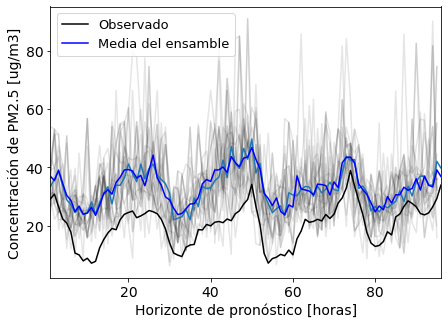

In [631]:
random_number = np.random.randint(5441)

plt.figure(figsize=(7,5))
# forecasts = []
# for i in range(100):
#     forecast_temp = scaler_y.inverse_transform(estimator.estimators_[i].\
#             predict(x_val[random_number].reshape(1, -1)))[0]
#     plt.plot(np.arange(1,97),forecast_temp,color='grey',alpha=0.1)
#     forecasts.append(forecast_temp)
# forecasts = np.array(forecasts)
for i in range(20):
    plt.plot(y_model_full[i,random_number],alpha=0.1,color='k')
plt.plot(np.arange(1,97),mean_temp[random_number])
plt.plot(np.arange(1,97),y_val[random_number],color='k',label = 'Observado')
plt.plot(np.arange(1,97),y_model[random_number],color='blue',label = 'Media del ensamble')
plt.xlim(1,96)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Concentración de PM2.5 [ug/m3]',fontsize=14)
plt.xlabel('Horizonte de pronóstico [horas]',fontsize=14)
plt.legend(fontsize=13)

In [363]:
estimator.clfs[0].estimators_[]

[DecisionTreeRegressor(max_features=10, random_state=1863427337),
 DecisionTreeRegressor(max_features=10, random_state=1025198295),
 DecisionTreeRegressor(max_features=10, random_state=1883427035),
 DecisionTreeRegressor(max_features=10, random_state=1596100682),
 DecisionTreeRegressor(max_features=10, random_state=909996542),
 DecisionTreeRegressor(max_features=10, random_state=1085772720),
 DecisionTreeRegressor(max_features=10, random_state=24430528),
 DecisionTreeRegressor(max_features=10, random_state=337596863),
 DecisionTreeRegressor(max_features=10, random_state=843134431),
 DecisionTreeRegressor(max_features=10, random_state=1323004671),
 DecisionTreeRegressor(max_features=10, random_state=1517815939),
 DecisionTreeRegressor(max_features=10, random_state=695685814),
 DecisionTreeRegressor(max_features=10, random_state=612710154),
 DecisionTreeRegressor(max_features=10, random_state=1565227845),
 DecisionTreeRegressor(max_features=10, random_state=1952934605),
 DecisionTreeRegr

20

In [655]:
np.sqrt(error)

6.4973192085437255

In [202]:
np.sqrt(mean_squared_error(y_val,y_model))

7.1610168984271825

In [13]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [14]:
def cross_validate_estimator(X,Y,estimator,n_splits = 5,gap=96):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    #Get splits
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    
    mses=[]
    for train_cv, test_cv in tscv.split(X=X_scaled):
        X_train_temp = X_scaled[train_cv]
        Y_train_temp = Y_scaled[train_cv]

        X_test_temp = X_scaled[test_cv]
        Y_test_temp = Y_scaled[test_cv]

        estimator.fit(X_train_temp,Y_train_temp)

        y_model = estimator.predict(X_test_temp)
        y_model = scaler_y.inverse_transform(y_model)
        y_val = scaler_y.inverse_transform(Y_test_temp)
        mses.append(mean_squared_error(y_model,y_val))
    return np.mean(mses)

In [15]:
import itertools

In [21]:
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

param_grid = {'bootstrap': [True],
 'max_samples': [0.8],
 'max_depth': [20, 80, 160, None],
 'max_features': ['sqrt', 80, 160, 320],
 'n_estimators': [200],
 'n_jobs': [60]}

In [22]:
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [23]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = RandomForestRegressor(**permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(estimator_temp)
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
RandomForestRegressor(max_depth=20, max_features='sqrt', max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.789259969541309
---- 1 ----
RandomForestRegressor(max_depth=20, max_features=80, max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.875337686805245
---- 2 ----
RandomForestRegressor(max_depth=20, max_features=160, max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.940048379408203
---- 3 ----
RandomForestRegressor(max_depth=20, max_features=320, max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.975922112783971
---- 4 ----
RandomForestRegressor(max_depth=80, max_features='sqrt', max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.786160430348394
---- 5 ----
RandomForestRegressor(max_depth=80, max_features=80, max_samples=0.8,
                      n_estimators=200, n_jobs=60)
6.88210859849637
---- 6 ----
RandomForestRegressor(max_depth=80, max_features=160, max_samples=0.8,
  

In [24]:
best_estimator = RandomForestRegressor(**permutations_dicts[np.argmin(MSE_estimators)])

In [25]:
def train_estimator(X,Y,estimator):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    estimator.fit(X_scaled,Y_scaled)
   
    return estimator

In [26]:
best_estimator = train_estimator(X,Y,best_estimator)

In [27]:
print(best_estimator)

RandomForestRegressor(max_features='sqrt', max_samples=0.8, n_estimators=200,
                      n_jobs=60)


In [29]:
print(np.min(np.sqrt(MSE_estimators)))

6.78290894333492


# 4. Feature Selection

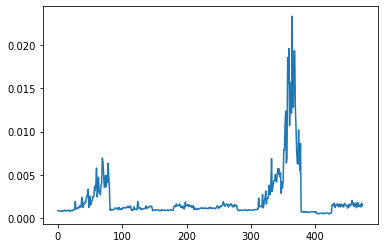

In [30]:
plt.plot(best_estimator.feature_importances_)

In [31]:
ordered_indices = np.argsort(best_estimator.feature_importances_)

In [37]:
## Iteracion 1
MSE_FS = []
for dropi in range(0,len(ordered_indices),10):
    X_temp = copy.deepcopy(X.iloc[:,ordered_indices[dropi:]])
    Y_temp = copy.deepcopy(Y)
    
    estimator_temp = RandomForestRegressor(max_features='sqrt', max_samples=0.8, n_estimators=200,
                      n_jobs=60)
    MSE_FS.append(cross_validate_estimator(X_temp,Y_temp,estimator_temp))
    print('---- '+str(dropi)+' ----')
    print(np.sqrt(MSE_FS[-1]))

---- 0 ----
6.7860543187729006
---- 10 ----
6.785851387535001
---- 20 ----
6.813467324509376
---- 30 ----
6.800671283983281
---- 40 ----
6.825718020170948
---- 50 ----
6.8233057664477945
---- 60 ----
6.824682071200912
---- 70 ----
6.837653553560108
---- 80 ----
6.817537816418934
---- 90 ----
6.820062055707463
---- 100 ----
6.816359324821726
---- 110 ----
6.816922511284811
---- 120 ----
6.811431056841786
---- 130 ----
6.815282748553
---- 140 ----
6.807643502853033
---- 150 ----
6.790659073460015
---- 160 ----
6.795561416841181
---- 170 ----
6.793707315636621
---- 180 ----
6.789178666031781
---- 190 ----
6.802186261707573
---- 200 ----
6.804970952313834
---- 210 ----
6.7997145326590305
---- 220 ----
6.807551393530772
---- 230 ----
6.811584106460688
---- 240 ----
6.827584564228925
---- 250 ----
6.819887802690805
---- 260 ----
6.835834827696448
---- 270 ----
6.850818222325983
---- 280 ----
6.843038127126202
---- 290 ----
6.8504570188692675
---- 300 ----
6.849820008143703
---- 310 ----
6.86

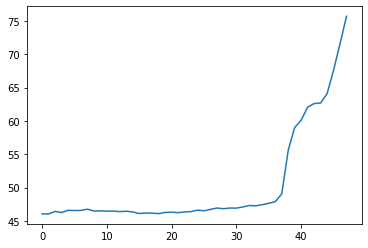

In [38]:
plt.plot(MSE_FS) 

#CONCLUSIÓN: NO HAY QUE HACER FEATURE SELECTION.

# 5. Full hyper-parameter optimization and training

## 5.1 Random Forests

In [58]:
param_grid = {'bootstrap': [False],
#  'max_samples': [0.2,0.4,0.6,0.8,1],
 'max_depth': [None],
 'max_features': [10, 20, 40, 80],
 'n_estimators': [300],
 'n_jobs': [60]}

keys, values = zip(*param_grid.items())
permutations_dicts1 = [dict(zip(keys, v)) for v in itertools.product(*values)]

param_grid = {'bootstrap': [True],
 'oob_score': [True],             
 'max_samples': [0.2,0.4,0.6,0.8,1],
 'max_depth': [None],
 'max_features': [10, 20, 40, 80],
 'n_estimators': [300],
 'n_jobs': [60]}

keys, values = zip(*param_grid.items())
permutations_dicts2 = [dict(zip(keys, v)) for v in itertools.product(*values)]

permutations_dicts = permutations_dicts1 + permutations_dicts2

In [59]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = RandomForestRegressor(**permutations_dicts[estimator_i])
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(estimator_temp)
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
RandomForestRegressor(bootstrap=False, max_features=10, n_estimators=300,
                      n_jobs=60)
6.746175657642129
---- 1 ----
RandomForestRegressor(bootstrap=False, max_features=20, n_estimators=300,
                      n_jobs=60)
6.789582272860482
---- 2 ----
RandomForestRegressor(bootstrap=False, max_features=40, n_estimators=300,
                      n_jobs=60)
6.849467061524368
---- 3 ----
RandomForestRegressor(bootstrap=False, max_features=80, n_estimators=300,
                      n_jobs=60)
6.944977178259226
---- 4 ----
RandomForestRegressor(max_features=10, max_samples=0.2, n_estimators=300,
                      n_jobs=60)
6.799479158266352
---- 5 ----
RandomForestRegressor(max_features=20, max_samples=0.2, n_estimators=300,
                      n_jobs=60)
6.8310165158943645
---- 6 ----
RandomForestRegressor(max_features=40, max_samples=0.2, n_estimators=300,
                      n_jobs=60)
6.839611795371825
---- 7 ----
RandomForestRegressor(max_fe

In [60]:
best_estimator = RandomForestRegressor(**permutations_dicts[np.argmin(MSE_estimators)])

In [61]:
best_estimator

RandomForestRegressor(bootstrap=False, max_features=10, n_estimators=300,
                      n_jobs=60)

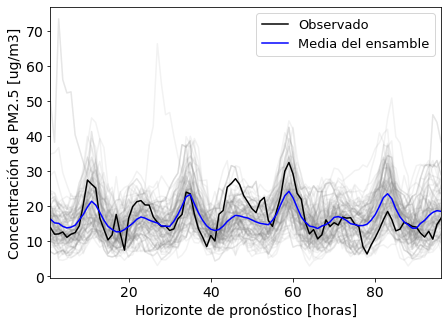

In [16]:
random_number = np.random.randint(6531)

plt.figure(figsize=(7,5))
forecasts = []
for i in range(100):
    forecast_temp = scaler_y.inverse_transform(estimator.estimators_[i].\
            predict(x_val[random_number].reshape(1, -1)))[0]
    plt.plot(np.arange(1,97),forecast_temp,color='grey',alpha=0.1)
    forecasts.append(forecast_temp)
forecasts = np.array(forecasts)

plt.plot(np.arange(1,97),y_val[random_number],color='k',label = 'Observado')
plt.plot(np.arange(1,97),y_model[random_number],color='blue',label = 'Media del ensamble')
plt.xlim(1,96)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Concentración de PM2.5 [ug/m3]',fontsize=14)
plt.xlabel('Horizonte de pronóstico [horas]',fontsize=14)
plt.legend(fontsize=13)

In [62]:
def create_data(N=1000):
    Y = np.vstack([np.random.normal([3, 8], [1, 3], (N // 2, 2)),
                   np.random.normal([8, 3], [3, 1], (N - N // 2, 2))])
    X = np.vstack([0.1 * Y[:, 0] * Y[:, 1],
                   np.sin(Y[:, 0]) * np.cos(Y[:, 1]),
                   np.cos(Y[:, 0]) * np.sin(Y[:, 1])]).T
    X = np.random.normal(X, 1.0)
    return X, Y

In [63]:
np.random.seed(0)
X, Y = create_data(1000)

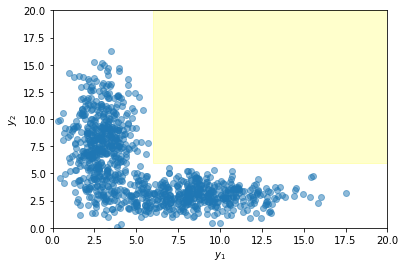

In [67]:

fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o', alpha=0.5)
ax.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
ax.set_xlim(0, 20); ax.set_ylim(0, 20)
ax.set_xlabel('$y_1$'); ax.set_ylabel('$y_2$');

In [69]:

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.5)

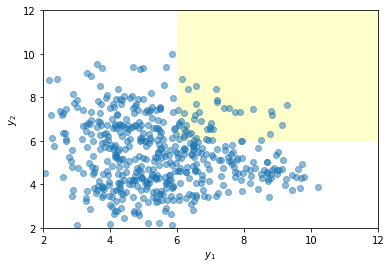

In [71]:
from sklearn.ensemble import RandomForestRegressor

clf1 = RandomForestRegressor(100).fit(Xtrain, Ytrain)
Ypred1 = clf1.predict(Xtest)

fig, ax = plt.subplots()
ax.plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.5)
ax.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
ax.set_xlim(2, 12); ax.set_ylim(2, 12)
ax.set_xlabel('$y_1$'); ax.set_ylabel('$y_2$');

In [72]:
class MultiOutputRF(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(Ny):
            clf = RandomForestRegressor(*self.args, **self.kwargs)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            self.clfs.append(clf.fit(Xi, yi))
            
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y

In [73]:
clf2 = MultiOutputRF(100).fit(Xtrain, Ytrain)
Ypred2 = clf2.predict(Xtest)

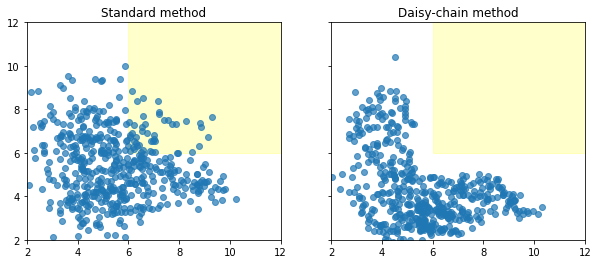

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    
ax[0].plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.7)
ax[1].plot(Ypred2[:, 0], Ypred2[:, 1], 'o', alpha=0.7)

ax[0].set_title("Standard method")
ax[1].set_title("Daisy-chain method")

for axi in ax:
    axi.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
    axi.set_xlim(2, 12)
    axi.set_ylim(2, 12)

In [75]:
clf2.clfs

[RandomForestRegressor(), RandomForestRegressor()]